# Descripción general de la red

Importar las librerias de networkx y wntr.

In [1]:
import networkx as nx
import wntr
import numpy as np
import matplotlib.pylab as plt
from IPython.display import HTML
import pickle

Importar el archivo de la red (*.inp) y se guarda en la variable 'wn'.

In [2]:
wn = wntr.network.WaterNetworkModel('nets/Chihuahua.inp')

Detalle de la red

In [3]:
wn.describe()

{'Nodes': 1327,
 'Links': 1570,
 'Patterns': 4,
 'Curves': 11,
 'Sources': 1,
 'Controls': 0}

## Mostramos la red

(<matplotlib.collections.PathCollection at 0x1ee327939d0>,
 <matplotlib.collections.LineCollection at 0x1ee27c4e220>)

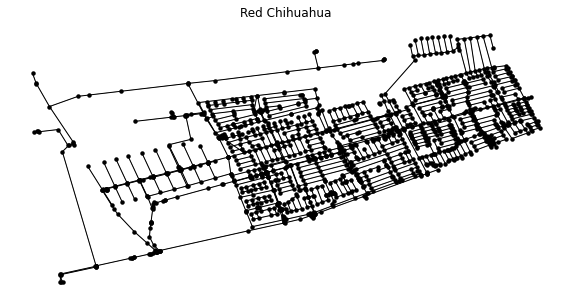

In [4]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, node_size=20, title='Red Chihuahua',ax=ax1)

# Metricas de Resilencia Topografica de la Red
## Densidad de enlaces

Para aplicar las métricas de resiliencia topográficas requieren que la red sea un grafo simple y no dirigido.
La variable 'wn' se convierte en un multigrafo dirigido representado con la variable 'G', posteriormente se utiliza para transformarla en un multigrafo no dirigido que se representa con la variable 'uG', por último esta variable se transforma en un grafo simple represntado con la variable 'sG'.

In [5]:
G = wn.get_graph() # directed multigraph
uG = G.to_undirected() # undirected multigraph
sG = nx.Graph(uG) # undirected simple graph

## Densidad

In [6]:
link_density = nx.density(G)
print(link_density)

0.0008922472240881744


## Diámetro

In [7]:
diameter = nx.diameter(uG)
print(diameter)

81


## Centralidad de intermediación
Calcular la intermedicación

In [8]:
betweenness_centrality = nx.betweenness_centrality(sG)
print(len(betweenness_centrality))

1327


Agregamos la intermediacion como atributo de los nodos

In [9]:
#itera entre todos los nodos de la red 
for node_name, node in wn.nodes():
    node.intermediacion = betweenness_centrality[node_name]

Graficamos la red de acuerdo a la intermediacion

(<matplotlib.collections.PathCollection at 0x1ee32c458e0>,
 <matplotlib.collections.LineCollection at 0x1ee32c98af0>)

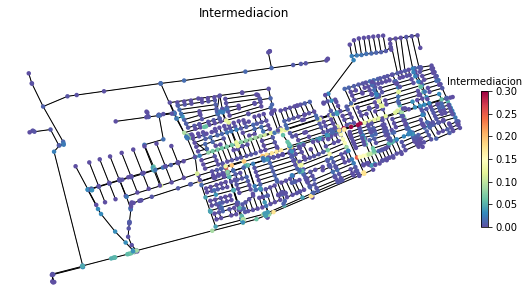

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Intermediacion', node_attribute='intermediacion',node_range=[0.3,0], node_colorbar_label='Intermediacion',ax=ax1)

## Excentricidad
Distancia al nodo más lejano

(<matplotlib.collections.PathCollection at 0x1ee32e51b80>,
 <matplotlib.collections.LineCollection at 0x1ee32e3fd60>)

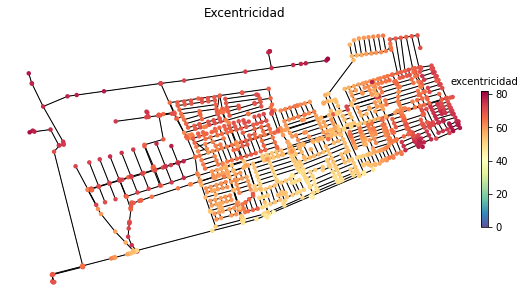

In [11]:
eccentricity = nx.eccentricity(uG)
for node_name, node in wn.nodes():
    node.excentricidad = eccentricity[node_name]
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Excentricidad', node_attribute='excentricidad',node_range=[0,82], node_colorbar_label='excentricidad',ax=ax1)

## Centralidad de cercanía
Reciproco de la suma de las distancias a todos los nodos

(<matplotlib.collections.PathCollection at 0x1ee33218c70>,
 <matplotlib.collections.LineCollection at 0x1ee331aee80>)

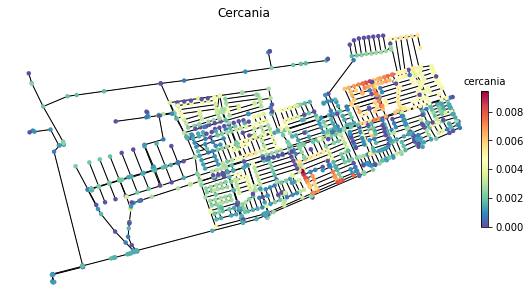

In [12]:
closeness_centrality = nx.closeness_centrality(G)
for node_name, node in wn.nodes():
    node.cercania = closeness_centrality[node_name]
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Cercania', node_attribute='cercania', node_colorbar_label='cercania',ax=ax1)

## Grado de nodo
Cantidad de enlaces que tiene un nodo

Calculamos el grado nodal

(<matplotlib.collections.PathCollection at 0x1ee3299dc70>,
 <matplotlib.collections.LineCollection at 0x1ee32e59fa0>)

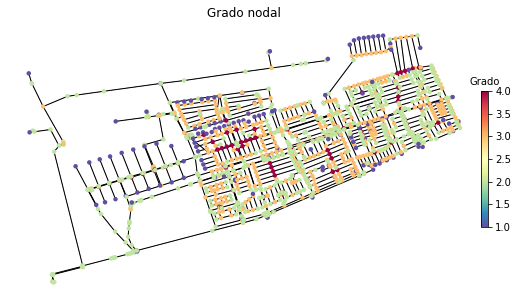

In [13]:
node_degree = G.degree()
#itera entre todos los nodos de la red 
for node_name, node in wn.nodes():
    node.grado = node_degree[node_name]
fig, (ax2) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Grado nodal', node_attribute='grado', node_colorbar_label='Grado',ax=ax2)

## Nodos terminales
Los nodos terminales son los de grado 1 (azules)

In [14]:
terminal_nodes = wntr.metrics.terminal_nodes(G)

Imprime la cantidad de nodos terminales

In [15]:
print(len(terminal_nodes))

157


## Puntos de articulación

In [16]:
articulation_points = list(nx.articulation_points(uG))

Imprime la cantidad de puntos de articulación

In [17]:
print(len(articulation_points))

319


## Puentes

In [18]:
bridges = wntr.metrics.bridges(G)

Imprime la cantidad de puentes

In [19]:
print(len(articulation_points))

319


# Métricas hidráulicas
Requieren de la simulación hidráulica de la red.

In [ ]:
wn.options.hydraulic.demand_model = 'PDD'
# Modify the water network model
duracion = 24*3600 #en segundos (1 dia)
intervalo_tiempo = 1800 # cada media hora
wn.options.time.duration = duracion
wn.options.time.hydraulic_timestep = intervalo_tiempo
wn.options.time.report_timestep = intervalo_tiempo #cada media hora registra resultados
wn.options.hydraulic.required_pressure = 21.09
wn.options.hydraulic.minimum_pressure = 0
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

Nodos y momentos en los que la presión (pressure) supera (np.greater) un umbral (threshold), utilizando los resultados de una simulación hidráulica.

In [ ]:
pressure = results.node['pressure']
threshold = 21.09 # 30 psi
pressure_above_threshold = wntr.metrics.query(pressure, np.greater,threshold)

Indica que nodos tienen presión por debajo del limite establecido (21.09 # 30 psi)

In [ ]:
print (pressure_above_threshold)

## Disponibilidad de servicio de agua

La poblacion la calcula como demanda_promedio_esperada / consumo per capita (R). Por default R=8.76157e-06 m3/s, esto se puede cambiar

In [ ]:
pop = wntr.metrics.population(wn)

Graficamos la población

In [ ]:
# Grafica interactiva
#wntr.graphics.plot_interactive_network(wn, title='Población', node_attribute=pop,node_range=[0,100], filename='population.html', auto_open=True)
# Grafica convencional
for node_name, node in wn.nodes():
    if node_name in pop.keys():
        node.population = pop[node_name]
    else:
        node.population = 0
fig, (ax2) = plt.subplots(1, 1, figsize=(10,5))
wntr.graphics.plot_network(wn, title='Población', node_attribute='population',node_range=[0,100], node_colorbar_label='Población',ax=ax2)

Si la demanda esperada es cero, el resultado es indefinido (NaN)

In [ ]:
expected_demand = wntr.metrics.expected_demand(wn)
demand = results.node['demand'].loc[:,wn.junction_name_list]

Calculo de la disponibilidad de servicio
wsa = suministro / demanda. Se puede calcular un promedio o calcular por cada nodo

In [279]:
wsa = wntr.metrics.water_service_availability(expected_demand, demand)  
wsa.index = wsa.index / 3600 #convierte el tiempo a horas
print(wsa.values)

[[nan  1. nan ...  1. nan nan]
 [nan  1. nan ...  1. nan nan]
 [nan  1. nan ...  1. nan nan]
 ...
 [nan  1. nan ...  1. nan nan]
 [nan  1. nan ...  1. nan nan]
 [nan  1. nan ...  1. nan nan]]


Simulacion de la disponibilidad de servicio de agua

<Figure size 432x288 with 0 Axes>

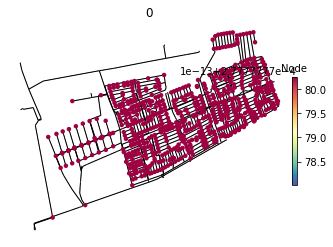

In [280]:
fig = plt.figure()
fig.subplots_adjust(bottom = 0)
fig.subplots_adjust(top = 1)
fig.subplots_adjust(right = 1)
fig.subplots_adjust(left = 0)
anim = wntr.graphics.network_animation(wn, node_attribute=wsa,repeat=True)

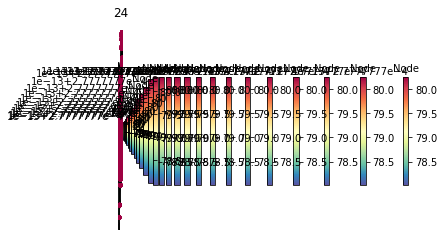

In [226]:
HTML(anim.to_html5_video())

Calculo del promedio de disponibilidad de servicio de agua y del nivel del tanque

In [281]:
# Average water service availability at each time
wsa_t = wntr.metrics.water_service_availability(expected_demand.sum(axis=1), demand.sum(axis=1))
wsa_t.index = wsa_t.index / 3600 #convierte el tiempo a horas
# Tank water level
tank_level = results.node['pressure'].loc[:,wn.tank_name_list]
tank_level.index = tank_level.index / 3600 #convierte el tiempo a horas

Grafica de la disponibilidad de servicio de agua

Text(0.5, 0, 'Tiempo (hrs.)')

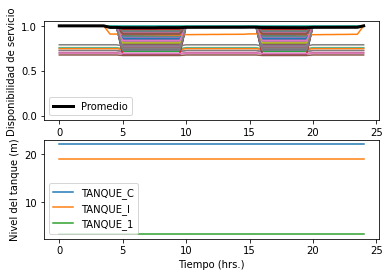

In [282]:
plt.figure()
 
plt.subplot(2,1,1)
wsa.plot(ax=plt.gca(), legend=False)
wsa_t.plot(ax=plt.gca(), label='Promedio', color='k', linewidth=3.0, legend=True)
plt.ylim( (-0.05, 1.05) )
plt.ylabel('Disponibilidad de servicio')
    
plt.subplot(2,1,2)
tank_level.plot(ax=plt.gca())
#plt.ylim(ymin=0, ymax=12)
plt.legend()
plt.ylabel('Nivel del tanque (m)')
plt.xlabel('Tiempo (hrs.)')

## Indice de Todini
El resultado se da en distintos momentos de tiempo

In [205]:
head = results.node['head']
pump_flowrate = results.link['flowrate'].loc[:,wn.pump_name_list]
todini = wntr.metrics.todini_index(head, pressure, demand, pump_flowrate, wn,threshold) # convert seconds to hours # convert seconds to hours

Graficamos el indice de Todini en el tiempo

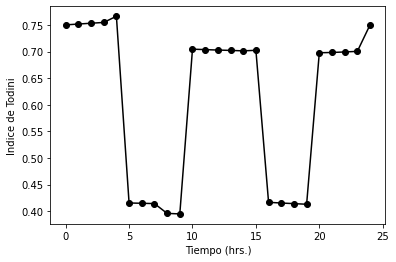

In [206]:
plt.xlabel("Tiempo (hrs.)")
plt.ylabel("Indice de Todini")
plt.plot(todini.keys()/3600, todini.values, '-ok');
plt.savefig("Todini.png")

# Simulacion de ataques

In [258]:
# Modify the water network model
duracion = 48*3600 #en segundos (2 dias)
intervalo_tiempo = 1800
wn.options.time.duration = duracion
wn.options.time.hydraulic_timestep = intervalo_tiempo
wn.options.time.report_timestep = intervalo_tiempo #cada media hora registra resultados
wn.options.hydraulic.required_pressure = 15
wn.options.hydraulic.minimum_pressure = 0

A cada tubería le asignamos un atributo que será el la suma de los grados de sus nodos adyacentes 

In [259]:
for pipe_name, pipe in wn.pipes():
    start_node = wn.get_node(pipe.start_node)
    end_node = wn.get_node(pipe.end_node)
    pipe.grado = start_node.grado + end_node.grado

Define la probabilidad de fallo para cada tubería basandose en el grado de sus nodos adjacentes
La probabilidad de fallo debe sumar 1.  

In [260]:
tuberia_grados = wn.query_link_attribute('grado',link_type=wntr.network.Pipe)
failure_probability = tuberia_grados/tuberia_grados.sum()

Guarda una copia del modelo de red en f

In [261]:
f=open('wn.pickle','wb')
pickle.dump(wn,f)
f.close()

# Run num_fallos realizations
results = {} # Initialize dictionary to store results
np.random.seed(67823) # Set random seed

In [262]:
num_fallos = 1
# Select the number of leaks, random value between 1 and num_fallos
N = np.random.randint(1,num_fallos+1)

# Select N unique pipes based on failure probability
pipes_to_fail = np.random.choice(failure_probability.index, num_fallos,replace=False,p=failure_probability.values)

# Select time of failure, uniform dist, between 1 and 10 hours
time_of_failure = np.round(np.random.uniform(1,10,1)[0], 2)

# Select duration of failure, uniform dist, between 12 and 6 hours
duration_of_failure = np.round(np.random.uniform(0,12,1)[0], 2)

In [263]:
# Add leaks to the model
for pipe_to_fail in pipes_to_fail:
    pipe = wn.get_link(pipe_to_fail)
    leak_diameter = pipe.diameter*0.3
    leak_area=3.14159*(leak_diameter/2)**2
    wn = wntr.morph.split_pipe(wn, pipe_to_fail, pipe_to_fail + '_B', pipe_to_fail+'leak_node')
    leak_node = wn.get_node(pipe_to_fail+'leak_node')
    leak_node.add_leak(wn, area=leak_area,start_time=time_of_failure*3600,end_time=(time_of_failure + duration_of_failure)*3600)

In [264]:
# Simulate hydraulics and store results
wn.options.hydraulic.demand_model = 'PDD'
sim = wntr.sim.WNTRSimulator(wn)
print('Pipe Breaks: ' + str(pipes_to_fail) + ', Start Time: ' + str(time_of_failure) + ', End Time: ' + \
            str(time_of_failure+duration_of_failure))
results = sim.run_sim()
    
# Reload the water network model
f=open('wn.pickle','rb')
wn = pickle.load(f)
f.close()

Pipe Breaks: ['T5623'], Start Time: 4.82, End Time: 6.82


In [267]:
def graficar():
     # Water service availability at each junction and time
    expected_demand = wntr.metrics.expected_demand(wn)
    demand = results.node['demand'].loc[:,wn.junction_name_list]
    wsa_nt = wntr.metrics.water_service_availability(expected_demand, demand)
    
    # Average water service availability at each time
    wsa_t = wntr.metrics.water_service_availability(expected_demand.sum(axis=1), 
                                                  demand.sum(axis=1))
                               
    # Tank water level
    tank_level = results.node['pressure'].loc[:,wn.tank_name_list]
    
    
    # Plot results
    plt.figure()
    
    plt.subplot(2,1,1)
    wsa_nt.index = wsa_nt.index / 3600 #convierte el tiempo a horas
    wsa_nt.plot(ax=plt.gca(), legend=False)
    wsa_t.index = wsa_t.index / 3600 #convierte el tiempo a horas
    wsa_t.plot(ax=plt.gca(), label='Promedio', color='k', linewidth=3.0, legend=True)
    plt.ylim( (-0.05, 1.05) )
    plt.ylabel('Disponibilidad de servicio')
    
    plt.subplot(2,1,2)
    tank_level.index = tank_level.index #/ 3600 convierte el tiempo a horas
    tank_level.plot(ax=plt.gca())
    #plt.ylim(ymin=0, ymax=12)
    plt.legend()
    plt.ylabel('Nivel del tanque (m)')
    plt.xlabel('Tiempo (hrs.)')

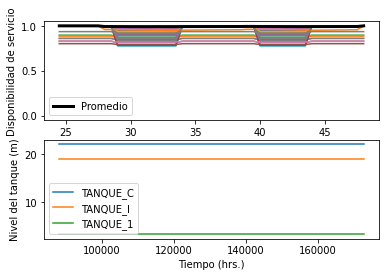

In [268]:
graficar()